In [1]:
import sys, os, time, fileinput
import numpy as np
import math as math 
from scipy.stats import maxwell, rv_histogram
import scipy.optimize as optimize
from scipy.interpolate import interp1d
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter

from astropy.table import Table

plt.style.use('default') 

rcParams.update({'figure.autolayout': True})
plt.rc('font', family='serif')
mpl.mathtext.fontset : 'dejavusans'

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['font.size'] = 30
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 28
mpl.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
mpl.rcParams['agg.path.chunksize'] = 10000
mpl.rcParams['text.usetex'] = True

/tmp/ipykernel_548/3665672662.py:28: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'png')


In [2]:
## halo fraction
log_f = 0.2 # halo fraction [setting max number of time steps]
f = 10**log_f
str_log_f = str.format('{0:.3f}',log_f)

# threshold fractional energy injection defining p_max
log_eps = -2.00
energy_fraction = 10**log_eps
str_log_eps = str.format('{0:.2f}',log_eps)

# ------------------------
## approximate number of encounters
log_K = np.log10(5000)
str_log_K = str.format('{0:.2f}',log_K)
# ------------------------
## list of a0-values
bin_scale = 'log'

log_alow = -5
str_log_alow = str.format('{0:.3f}',log_alow)
log_ahigh = 2
str_log_ahigh = str.format('{0:.3f}',log_ahigh)
step_size = 0.04 # number of bins
str_step_size = str(step_size)
#str_step_size = str.format('{0:.3f}',step_size)

log_alow_offset = 0
str_log_alow_offset = str.format('{0:.3f}',log_alow_offset)
log_ahigh_offset = 0
str_log_ahigh_offset = str.format('{0:.3f}',log_ahigh_offset)

# ------------------------
## emcee parameters
nwalkers = int(200)
str_nwalkers = str(nwalkers)

burn = int(200)
str_burn = str(burn)

n_steps = int(600)
str_n_steps = str(n_steps)

In [ ]:
plt.rcParams['axes.labelsize'] = 30 * 3 / 2
plt.rcParams['axes.titlesize'] = 28 * 3 / 2
plt.rcParams['legend.title_fontsize'] = 28 * 3 / 2
plt.rcParams['font.size'] = 30  * 3 / 2
plt.rcParams['lines.linewidth'] = 2 * 3 / 2
plt.rcParams['lines.markersize'] = 8 * 3 / 2
plt.rcParams['legend.fontsize'] = 28 * 3 / 2

# ======================
# ======================
log_rslist = [-2,-1,0,1]
alpha_list = [0,-1,-2,-3]

results_list_fp_vs_Mp = []

Na = len(alpha_list)
for na in range(Na):
    alpha = alpha_list[na]
    str_alpha = str.format('{0:.3f}',alpha)
    
    cmap = plt.get_cmap('Reds')
    color_codes = [0.9, 0.65, 0.4, 0.25]
    ncolor = 0
    
    log_mlist_list = []
    log_fp_list = []
    
    for log_rs in log_rslist:
        color_code = color_codes[ncolor]
        color = cmap(color_code)
        ncolor += 1
        
        str_log_rs = str.format('{0:.3f}',log_rs)

        local_dir = "data/eDR3_plaws/"
        RESULTS_DIR = (local_dir+"emcee_data/"+str_log_rs+'_'+str_alpha+'_'+str_log_f+'_'+str_log_eps+'_'
                       +str_log_K+'_'+bin_scale+'_'+str_log_alow+'_'
                       +str_log_ahigh+'_'+str_step_size+'_'+str_log_alow_offset+'_'
                       +str_log_ahigh_offset+'_'+str_nwalkers+'_'+str_burn+'_'+str_n_steps )

        log_f_minus_2sigma = []
        log_f_center = []
        log_f_1sigma = []
        log_f_2sigma = []
    #    log_mlist_low = np.arange(1.7,3+0.1,0.1)
    #    log_mlist_high = np.arange(3,8+1,1)
    #    log_mlist = np.union1d(log_mlist_low, log_mlist_high)
        
        if alpha == -1 or alpha == 0:               
            if log_rs >= 0:
                log_mlist_low = np.arange(2.8 + 2* log_rs,2.8 + 1.2 + 2* log_rs,0.2)
                log_mlist_high = np.arange(2.8 + 1.2 + 2* log_rs,8+1,1)
                log_mlist_rs = np.flip( np.union1d(log_mlist_low, log_mlist_high) )
            else:
                log_mlist_low = np.arange(1.6,3,0.2)
                log_mlist_high = np.arange(3,8+1,1)
                log_mlist_rs = np.flip( np.union1d(log_mlist_low, log_mlist_high) ) 
        elif alpha == -2:
            if log_rs >= 0:
                log_mlist_low = np.arange(2.6 + 2* log_rs,2.6 + 1.4 + 2* log_rs,0.2)
                log_mlist_high = np.arange(2.6 + 1.4 + 2* log_rs,8+1,1)
                log_mlist_rs = np.flip( np.union1d(log_mlist_low, log_mlist_high) )
            else:
                log_mlist_low = np.arange(1.6,3,0.2)
                log_mlist_high = np.arange(3,8+1,1)
                log_mlist_rs = np.flip( np.union1d(log_mlist_low, log_mlist_high) ) 
        elif alpha == -2.5:
            if log_rs == 0:
                log_mlist_low = np.arange(2.2 + 2* log_rs,2.6 + 1.4 + 2* log_rs,0.2)
                log_mlist_high = np.arange(2.6 + 1.4 + 2* log_rs,8+1,1)
                log_mlist_rs = np.flip( np.union1d(log_mlist_low, log_mlist_high) )
            elif log_rs == 1:
                log_mlist_low = np.arange(3.4,2.6 + 1.4 + 2* log_rs,0.2)
                log_mlist_high = np.arange(2.6 + 1.4 + 2* log_rs,8+1,1)
                log_mlist_rs = np.flip( np.union1d(log_mlist_low, log_mlist_high) )
            else:
                log_mlist_low = np.arange(1.6,3,0.2)
                log_mlist_high = np.arange(3,8+1,1)
                log_mlist_rs = np.flip( np.union1d(log_mlist_low, log_mlist_high) ) 
        elif alpha == -3:
            log_mlist_low = np.arange(1.6,3,0.2)
            log_mlist_high = np.arange(3,8+1,1)
            log_mlist_rs = np.flip( np.union1d(log_mlist_low, log_mlist_high) )

        log_mlist = log_mlist_rs

        #log_mlist = np.arange(1,8+1,1)
        #log_mlist_low = np.arange(1.5,3,0.25)
        #log_mlist_high = np.arange(3, 8+1, 1)
        #log_mlist = np.flip( np.union1d(log_mlist_low, log_mlist_high) )

        for log_m in log_mlist:
            str_log_m = str.format('{0:.3f}',log_m)
            file_name = ( 'emcee_splaw_' + str_log_m + '_' + str_log_K + '_'
                         + bin_scale + '_' + str_log_alow + '_' + str_log_ahigh + '_' + str_step_size + '_'
                         + str_log_alow_offset + '_' + str_log_ahigh_offset + '_'
                         + str_nwalkers + '_' + str_burn + '_' + str_n_steps )

            file_loc = RESULTS_DIR + '/' + file_name + '.npy'
            results = np.load(file_loc, allow_pickle = True)

            emcee_res = results[0]
            flatchain = emcee_res[0]
            mcmc = np.percentile(flatchain[:, -1], [5, 50, 68, 95])  # 2 sigma constraints
            #print(mcmc)
            log_f_2sigma.append(mcmc[-1])
            log_f_center.append(mcmc[1])
            log_f_minus_2sigma.append(mcmc[0])
            log_f_1sigma.append(mcmc[-2])

        log_mlist = np.array(log_mlist)
        log_f_2sigma = np.array(log_f_2sigma)
        log_f_center = np.array(log_f_center)
        log_f_1sigma = np.array(log_f_1sigma)
        log_f_minus_2sigma = np.array(log_f_minus_2sigma)
        
        log_mlist_list.append(log_mlist)
        log_fp_list.append(log_f_2sigma)
    
        results_list_fp_vs_Mp_alpha = [log_mlist_list, log_fp_list]
    results_list_fp_vs_Mp.append(results_list_fp_vs_Mp_alpha)
    
np.save('fp_vs_Mp_plots', results_list_fp_vs_Mp)

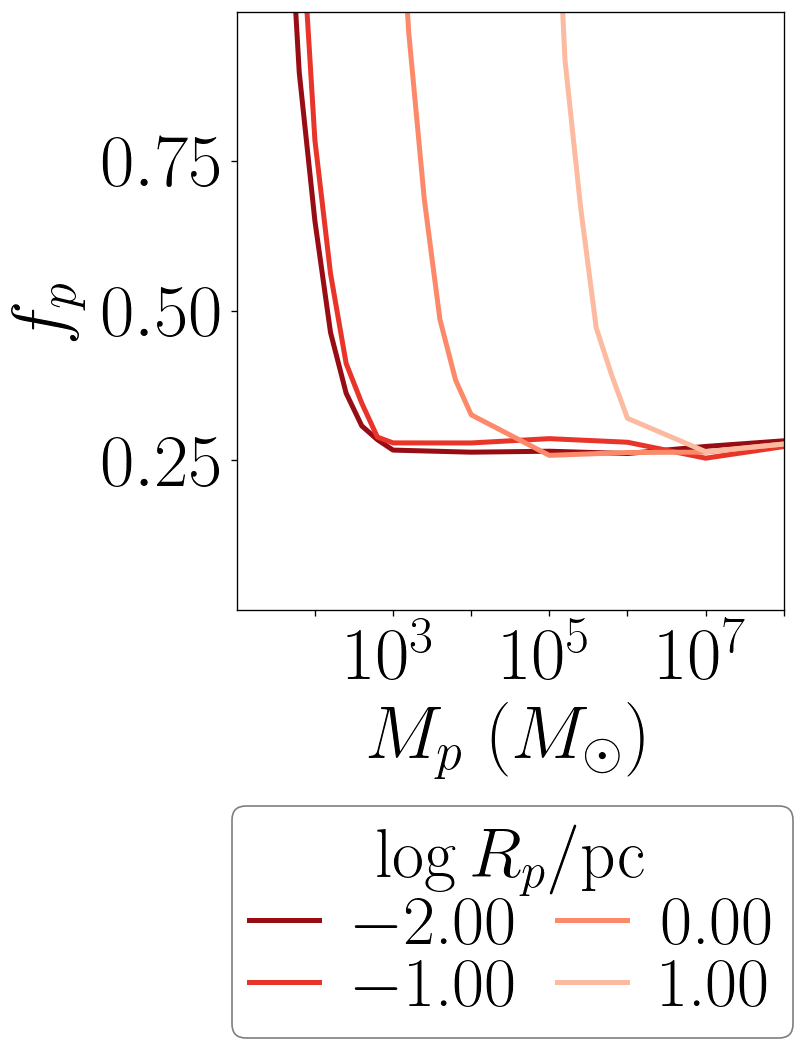

In [4]:
results_list_fp_vs_Mp = np.load('fp_vs_Mp_plots.npy', allow_pickle = True)

plt.rcParams['axes.labelsize'] = 30 * 3 / 2
plt.rcParams['axes.titlesize'] = 28 * 3 / 2
plt.rcParams['legend.title_fontsize'] = 28 * 3 / 2
plt.rcParams['font.size'] = 30  * 3 / 2
plt.rcParams['lines.linewidth'] = 2 * 3 / 2
plt.rcParams['lines.markersize'] = 8 * 3 / 2
plt.rcParams['legend.fontsize'] = 28 * 3 / 2

fig = plt.figure(figsize=(20,22), dpi= 120)

# ======================
# ======================
log_rslist = [-2,-1,0,1]
alpha_list = [0]

Na = len(alpha_list)

for na in range(Na):
    alpha = alpha_list[na]
    str_alpha = str.format('{0:.3f}',alpha)
    
    ax = plt.subplot2grid((3,3),(na,0))
    
    cmap = plt.get_cmap('Reds')
    color_codes = [0.9, 0.65, 0.4, 0.25]
    ncolor = 0
    
    results_list_fp_vs_Mp_alpha = results_list_fp_vs_Mp[na]
    log_mlist_list, log_fp_list = results_list_fp_vs_Mp_alpha
    
    for nrs in range(len(log_rslist)):
        color_code = color_codes[ncolor]
        color = cmap(color_code)
        ncolor += 1
        
        log_rs = log_rslist[nrs]
        str_log_rs = str.format('{0:.3f}',log_rs)
        
        local_dir = "data/eDR3_plaws/"
        RESULTS_DIR = (local_dir+"emcee_data/"+str_log_rs+'_'+str_alpha+'_'+str_log_f+'_'+str_log_eps+'_'
                       +str_log_K+'_'+bin_scale+'_'+str_log_alow+'_'
                       +str_log_ahigh+'_'+str_step_size+'_'+str_log_alow_offset+'_'
                       +str_log_ahigh_offset+'_'+str_nwalkers+'_'+str_burn+'_'+str_n_steps )
        
        log_mlist = log_mlist_list[nrs]
        log_f_2sigma = log_fp_list[nrs]
        
        if log_rs < 0:
            str_log_rs = '$-$' + str.format('{0:.2f}',-log_rs)
        else:
            str_log_rs = str.format('{0:.2f}',log_rs)
        ax.plot(10**log_mlist,10**log_f_2sigma, alpha = 1, label = str_log_rs, color = color)
        
        ax.set_ylabel('$f_{p}$', labelpad = 10)
        #ax.set_title('MACHO Constraints')


        ax.set_xscale('log')
        ax.set_yscale('linear')
        ax.set_xlim([10**1, 10**8])
        ax.set_ylim([0.001,0.999])
        
        locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)

        # This allows us to manually modify tick labels
        ax.set_xticks(np.logspace(2,8,7))
        plt.draw()

        labels = [item.get_text() for item in ax.get_xticklabels()]
        for n in range(0,len(labels),2): labels[n] = ' ' 

        ax.set_xticklabels(labels)
        ax.tick_params(axis='x', pad=7.5)  
        
        ax.set_xlabel('$M_{p} \ (M_{\odot})$')
        lgnd = ax.legend(frameon = True, framealpha = 0.5, edgecolor = 'black', title = '$\\log R_{p} / { \\rm pc}$', ncol = 2, handletextpad=0.5,
                     borderpad=0.25, handlelength = 1, bbox_to_anchor=(1.08, -0.775), loc='lower right', 
                 columnspacing = 0.5, labelspacing = 0)
        lgnd._legend_box.align = 'center'
        
#         lgnd = ax.legend(frameon = False, title = '$\\log R / { \\rm pc}$', ncol = 2, handletextpad=0.5,
#                      borderpad=0.25, handlelength = 1, bbox_to_anchor=(1.075, 0.5), loc='lower right', 
#                  columnspacing = 1, labelspacing = 0.1)
#         lgnd._legend_box.align = 'right'

In [28]:
log_mlist = [5,4,3,2]
alpha_list = [0,-1,-2,-3]

results_list_fp_vs_rs = []

Na = len(alpha_list)
for na in range(Na):
    alpha = alpha_list[na]
    str_alpha = str.format('{0:.3f}',alpha)

    cmap = plt.get_cmap('Blues')
    color_codes = [0.9, 0.65, 0.4, 0.25]
    ncolor = 0
    
    log_rslist_list = []
    log_fp_list = []
    for log_m in log_mlist:
        color_code = color_codes[ncolor]
        color = cmap(color_code)
        ncolor += 1
        
        str_log_m = str.format('{0:.3f}',log_m)
        #[4,3,2,1]

        if alpha == 0:
            #[4,3,2,1]
            if log_m == 5:
                log_rslist_low = np.arange(-2,0,0.5)
                log_rslist_high = np.arange(0,1.2+0.2,0.2)
                log_rslist = np.union1d(log_rslist_low, log_rslist_high)
            elif log_m == 4:
                log_rslist_low = np.arange(-2,-0.5+0.5,0.5)
                log_rslist_high = np.arange(-0.4,0.8+0.2,0.2)
                log_rslist = np.union1d(log_rslist_low, log_rslist_high)
            elif log_m == 3:
                log_rslist_low = np.arange(-2,-1+0.5,0.5)
                log_rslist_mid = np.arange(-0.9,0+0.2,0.2)
                log_rslist = np.union1d(log_rslist_low, log_rslist_mid)
            elif log_m == 2:
                log_rslist = np.arange(-2,-0.6,0.2)
            elif log_m == 1:
                log_rslist = np.arange(-2,2+1,1)

        if alpha == -1:
            #[4,3,2,1]
            if log_m == 5:
                log_rslist_low = np.arange(-2,0,0.5)
                log_rslist_high = np.arange(0,1.2+0.2,0.2)
                log_rslist = np.union1d(log_rslist_low, log_rslist_high)
            elif log_m == 4:
                log_rslist_low = np.arange(-2,0+0.5,0.5)
                log_rslist_high = np.arange(-0.4,0.8+0.2,0.2)
                log_rslist = np.union1d(log_rslist_low, log_rslist_high)
            elif log_m == 3:
                log_rslist_low = np.arange(-2,-1.5+0.5,0.5)
                log_rslist_mid = np.arange(-0.9,0+0.2,0.2)
                log_rslist = np.union1d(log_rslist_low, log_rslist_mid)
            elif log_m == 2:
                log_rslist = np.arange(-2,-0.6,0.2)
            elif log_m == 1:
                log_rslist = np.arange(-2,2+1,1)


        if alpha == -2:
            #[4,3,2,1]
            if log_m == 5:
                log_rslist_low = np.arange(-2,0,0.5)
                log_rslist_high = np.arange(0,1.4+0.2,0.2)
                log_rslist = np.union1d(log_rslist_low, log_rslist_high)
            elif log_m == 4:
                log_rslist_low = np.arange(-2,0+0.5,0.5)
                log_rslist_high = np.arange(-0.4,0.8+0.2,0.2)
                log_rslist = np.union1d(log_rslist_low, log_rslist_high)
            elif log_m == 3:
                log_rslist_low = np.arange(-2,-1,0.5)
                log_rslist_mid = np.arange(-1,0.4+0.2,0.2)
                log_rslist = np.union1d(log_rslist_low, log_rslist_mid)
            elif log_m == 2:
                log_rslist = np.arange(-2,-0.6,0.2)
            elif log_m == 1:
                log_rslist = np.arange(-2,2+1,1)

        if alpha == -2.5:
            #[4,3,2,1]c
            if log_m == 5:
                log_rslist_low = np.arange(-2,0,0.5)
                log_rslist_high = np.arange(0,1.8+0.2,0.2)
                log_rslist = np.union1d(log_rslist_low, log_rslist_high)
            elif log_m == 4:
                log_rslist_low = np.arange(-2,0,0.5)
                log_rslist_high = np.arange(0,1.4+0.2,0.2)
                log_rslist = np.union1d(log_rslist_low, log_rslist_high)
            elif log_m == 3:
                log_rslist_low = np.arange(-2,-1,0.5)
                log_rslist_mid = np.arange(-1,0.6+0.2,0.2)
                log_rslist = np.union1d(log_rslist_low, log_rslist_mid)
            elif log_m == 2:
                log_rslist = np.arange(-2,-0.4,0.2)
            elif log_m == 1:
                log_rslist = np.arange(-2,2+1,1)

        if alpha == -3:
            #[4,3,2,1]
            log_rslist = np.arange(-2,2+0.5,0.5)

        log_f_minus_2sigma = []
        log_f_center = []
        log_f_1sigma = []
        log_f_2sigma = []

        for log_rs in log_rslist:
            str_log_rs = str.format('{0:.3f}',log_rs)
    
            username = 'ramirez'
            local_dir = "data/eDR3_plaws/"
            RESULTS_DIR = (local_dir+"emcee_data/"+str_log_rs+'_'+str_alpha+'_'+str_log_f+'_'+str_log_eps+'_'
                           +str_log_K+'_'+bin_scale+'_'+str_log_alow+'_'
                           +str_log_ahigh+'_'+str_step_size+'_'+str_log_alow_offset+'_'
                           +str_log_ahigh_offset+'_'+str_nwalkers+'_'+str_burn+'_'+str_n_steps )

            file_name = ( 'emcee_splaw_' + str_log_m + '_' + str_log_K + '_'
                         + bin_scale + '_' + str_log_alow + '_' + str_log_ahigh + '_' + str_step_size + '_'
                         + str_log_alow_offset + '_' + str_log_ahigh_offset + '_'
                         + str_nwalkers + '_' + str_burn + '_' + str_n_steps )
        
            file_loc = RESULTS_DIR + '/' + file_name + '.npy'
            results = np.load(file_loc, allow_pickle = True)

            emcee_res = results[0]
            flatchain = emcee_res[0]
            mcmc = np.percentile(flatchain[:, -1], [5, 50, 68, 95])  # 2 sigma constraints
            #print(mcmc)
            log_f_2sigma.append(mcmc[-1])
            log_f_center.append(mcmc[1])
            log_f_minus_2sigma.append(mcmc[0])
            log_f_1sigma.append(mcmc[-2])

        if log_m == 1:
            print(log_f_2sigma)
        else:
            log_mlist = np.array(log_mlist)
            log_f_2sigma = np.array(log_f_2sigma)
            log_f_center = np.array(log_f_center)
            log_f_1sigma = np.array(log_f_1sigma)
            log_f_minus_2sigma = np.array(log_f_minus_2sigma)
        
        log_rslist_list.append(log_rslist)
        log_fp_list.append(log_f_2sigma)
            
        results_list_fp_vs_rs_alpha = [log_rslist_list, log_fp_list]
    results_list_fp_vs_rs.append(results_list_fp_vs_rs_alpha)
    
np.save('fp_vs_rs_plots', results_list_fp_vs_rs)

/home/edr/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


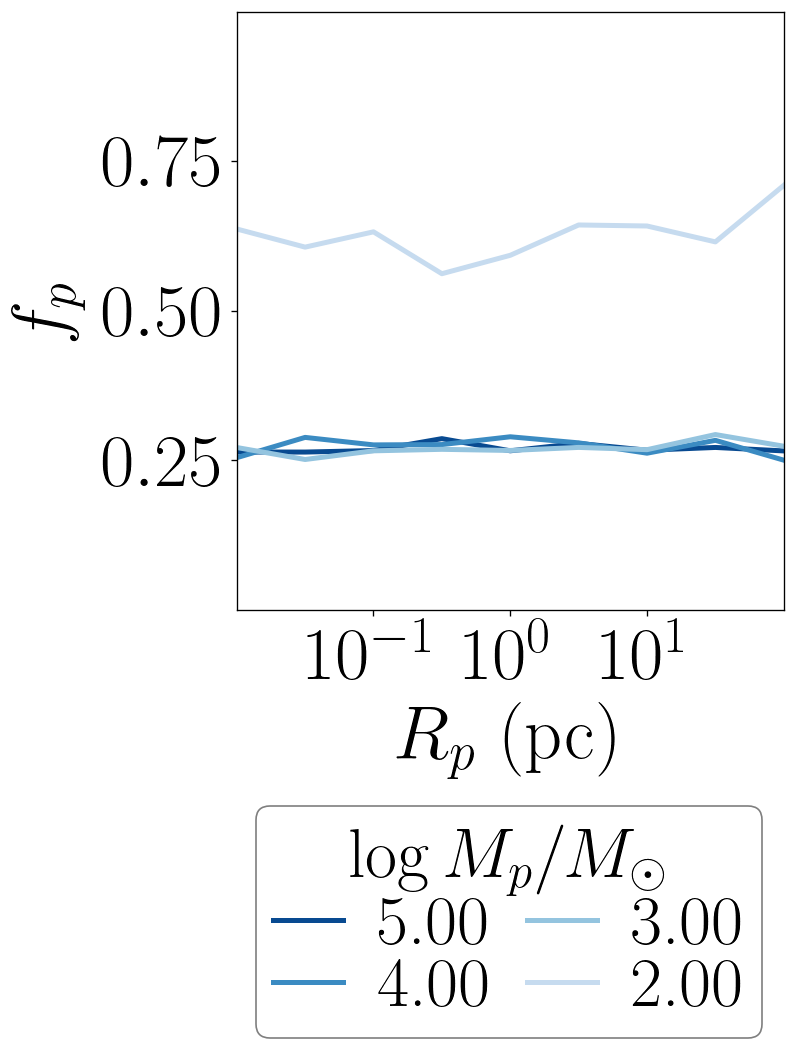

In [32]:
results_list_fp_vs_rs = np.load('fp_vs_rs_plots.npy', allow_pickle = True)

plt.rcParams['axes.labelsize'] = 30 * 3 / 2
plt.rcParams['axes.titlesize'] = 28 * 3 / 2
plt.rcParams['legend.title_fontsize'] = 28 * 3 / 2
plt.rcParams['font.size'] = 30  * 3 / 2
plt.rcParams['lines.linewidth'] = 2 * 3 / 2
plt.rcParams['lines.markersize'] = 8 * 3 / 2
plt.rcParams['legend.fontsize'] = 28 * 3 / 2

fig = plt.figure(figsize=(20,22), dpi= 120)

# ======================
# ======================
log_mlist = [5,4,3,2]
alpha_list = [0]

Na = len(alpha_list)

for na in range(Na):
    alpha = alpha_list[na]
    str_alpha = str.format('{0:.3f}',alpha)
    
    ax = plt.subplot2grid((3,3),(na,1))
    
    cmap = plt.get_cmap('Blues')
    color_codes = [0.9, 0.65, 0.4, 0.25]
    ncolor = 0
    
    results_list_fp_vs_rs_alpha = results_list_fp_vs_rs[3]
    log_rslist_list, log_fp_list = results_list_fp_vs_rs_alpha
    
    for nm in range(len(log_mlist)):
        color_code = color_codes[ncolor]
        color = cmap(color_code)
        ncolor += 1
        
        log_rslist = log_rslist_list[nm]
        log_f_2sigma = log_fp_list[nm]
        
        log_m = log_mlist[nm]
        str_log_m = str.format('{0:.2f}',log_m)
        ax.plot(10**log_rslist,10**log_f_2sigma, alpha = 1, label = str_log_m, color = color)
        
        ax.set_ylabel('$f_{p}$', labelpad = 10)
        #ax.set_title('MACHO Constraints')
        #ax.legend()

        ax.set_xscale('log')
        ax.set_yscale('linear')
        ax.set_xlim([10**-2, 10**2])
        ax.set_ylim([0.001,0.999])

        locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)

        # This allows us to manually modify tick labels
        ax.set_xticks(np.logspace(-1,1,3))
        plt.draw()

        labels = [item.get_text() for item in ax.get_xticklabels()]
        #for n in range(1,len(labels),2): labels[n] = ' ' 

        ax.set_xticklabels(labels)
        ax.tick_params(axis='x', pad=7.5)  

    #    locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)
    #    ax.xaxis.set_minor_locator(locmin_x)
    #    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

        # This allows us to manually modify tick labels
    #    ax.set_xticks(np.logspace(1,8,8))
        plt.draw()

    #    labels = [item.get_text() for item in ax.get_xticklabels()]
    #    for n in range(0,len(labels),2): labels[n] = ' ' 

    #    ax.set_xticklabels(labels)

        #ax.axhline(y = 1, ls = '--', lw = 1, c = 'k')
        ax.set_xlabel('$R_{p} \ ({\\rm pc})$')

        lgnd = ax.legend(frameon = True, framealpha = 0.5, edgecolor = 'black', ncol = 2, title = '$\\log M_{p}/M_{\odot}$', handletextpad=0.5,
                 borderpad=0.25, handlelength = 1, bbox_to_anchor=(1.025, -0.775), loc='lower right', 
                 columnspacing = 0.5, labelspacing = 0)
        lgnd._legend_box.align = 'center'
#             lgnd = ax.legend(frameon = False, ncol = 2, title = '$\\log M_{p}/M_{\odot}$', handletextpad=0.5,
#                      borderpad=0.25, handlelength = 1, bbox_to_anchor=(0.75, 0.55), loc='lower right', 
#                      columnspacing = 1, labelspacing = 0.01)
#             lgnd._legend_box.align = 'left'
        #lgnd = ax.legend(ncol=1, frameon = False, handletextpad=0.25, 
         #borderpad=0.25, handlelength = 0.5, loc='best', bbox_to_anchor=(0.5, 0.6, 0, 0.5))